In [1]:
import psycopg2

In [2]:
con = psycopg2.connect(user = "postgres",
                       password = "",
                       host = "127.0.0.1",
                       port = "5432",
                       database = "adj_noun_pairs")

try:
    cursor = con.cursor();
except (Exception, psycopg2.Error) as error:
    print("Error in Connection",error)

In [7]:
try:
    cursor.execute("SELECT * FROM pair_counts_10000 WHERE noun IN (SELECT noun FROM pair_counts_10000 GROUP BY noun HAVING COUNT(*) >= 5)")
    pairs = cursor.fetchall() 
except (Exception, psycopg2.Error) as error:
    con.rollback()
    print("Error while inserting data into the table:", error)

In [8]:
len(pairs)

284340

In [9]:
adjs = list(set([pair[0] for pair in pairs]))
nouns = list(set([pair[1] for pair in pairs]))

In [10]:
print(len(nouns), len(adjs))

10521 20266


### Finding similarities of words

Deciding the similarity of each pair of two different nouns based on how many adjectives they have in common (adjectives that were used to describe them in the texts).

In [29]:
try:
    cursor.execute("SELECT DISTINCT noun, STRING_AGG(adjective, ',') FROM pair_counts_10000 WHERE noun IN (SELECT noun FROM pair_counts_10000 GROUP BY noun HAVING COUNT(*) >= 5) GROUP BY noun")
    adjectives_listed = cursor.fetchall() 
except (Exception, psycopg2.Error) as error:
    con.rollback()
    print("Error while inserting data into the table:", error)

In [32]:
adjectives_listed[:3]

[('iseolemine',
  'sõjaeelne,kultuuriline,poliitiline,tavapärane,riiklik,muutumatu,ideoloogilis-poliitiline,rahvuslik'),
 ('detektor',
  'piisav,tundlik,iseloomulik,tulnud,mõõtev,suur,vastav,armetu,uus,kuuluv'),
 ('aastamiljon', 'pikk,püsiv,järgnev,terve,viimane,energeetiline')]

In [31]:
dict_words = {}

for tup in adjectives_listed:
    dict_words[tup[0]] = tup[1].split(',')

In [14]:
import itertools

In [17]:
noun_pairs = list(itertools.combinations(nouns, 2))

In [18]:
len(noun_pairs)

55340460

In [25]:
noun_pairs[0]

('kitsendus', 'festival')

In [33]:
len(set(dict_words['kitsendus']) & set(dict_words['festival']))/len(set(dict_words['kitsendus']) | set(dict_words['festival']))

0.0273972602739726

In [40]:
import time
from datetime import timedelta, datetime

In [45]:
print(str(timedelta(seconds=time.time()+7200)).split(", ")[1])
start = datetime.now()

similarities = {}

for pair in noun_pairs:
    first_word = pair[0]
    second_word = pair[1]
    similarities[pair] = len(set(dict_words[first_word]) & set(dict_words[second_word]))/len(set(dict_words[first_word]) | set(dict_words[second_word]))
    
print(str(timedelta(seconds=time.time()+7200)).split(", ")[1])
print(datetime.now()-start)

23:26:58.899620
23:43:30.172390
0:16:31.311651


In [53]:
similarities2 = {}

for pair, similarity in similarities.items():
    first = pair[0]
    second = pair[1]
    
    if first in similarities2:
        similarities2[first][second] = similarity
    else:
        similarities2[first] = {second: similarity}
        
    if second in similarities2:
        similarities2[second][first] = similarity
    else:
        similarities2[second] = {first: similarity}

### t-SNE on similarity matrix

In [48]:
import time
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.patheffects as PathEffects
%matplotlib inline

C:\Users\Birgit\Anaconda3\envs\py36_estnltk\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\Birgit\Anaconda3\envs\py36_estnltk\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [50]:
import pandas as pd

In [54]:
df = pd.DataFrame(similarities2)

In [55]:
df

,kitsendus,festival,maksulaekumine,säilitamine,minimeerimine,kraam,müügihind,sundus,põllumajandusminister,ennust,...,terviklikkus,poolkera,hotellituba,etteheide,otstarbekus,tähtaeg,avaldusvorm,teatrimärk,lähitulevik,kompartei
festival,0.027397,NaN,0.000000,0.055118,0.000000,0.039604,0.057971,0.015152,0.066667,0.000000,...,0.000000,0.0,0.000000,0.012987,0.013514,0.042735,0.000000,0.015873,0.046875,0.038961
maksulaekumine,0.041667,0.000000,NaN,0.012048,0.000000,0.000000,0.045455,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.014085,0.000000,0.000000,0.000000,0.034483
säilitamine,0.010638,0.055118,0.012048,NaN,0.011494,0.016260,0.021978,0.011628,0.024390,0.000000,...,0.057471,0.0,0.024096,0.031579,0.021505,0.051852,0.012346,0.000000,0.023529,0.041667
minimeerimine,0.074074,0.000000,0.000000,0.011494,NaN,0.000000,0.038462,0.000000,0.000000,0.058824,...,0.040000,0.0,0.000000,0.066667,0.000000,0.041096,0.000000,0.000000,0.000000,0.000000
kraam,0.015385,0.039604,0.000000,0.016260,0.000000,NaN,0.049180,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.014706,0.000000,0.036697,0.000000,0.018519,0.017544,0.044118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
avaldusvorm,0.000000,0.000000,0.000000,0.012346,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000
teatrimärk,0.041667,0.015873,0.000000,0.000000,0.000000,0.018519,0.045455,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.014085,0.000000,NaN,0.000000,0.034483
lähitulevik,0.000000,0.046875,0.000000,0.023529,0.000000,0.017544,0.083333,0.052632,0.062500,0.000000,...,0.041667,0.0,0.000000,0.000000,0.000000,0.041667,0.000000,0.000000,NaN,0.031250
kompartei,0.051282,0.038961,0.034483,0.041667,0.000000,0.044118,0.026316,0.000000,0.034483,0.000000,...,0.000000,0.0,0.000000,0.000000,0.025000,0.035294,0.000000,0.034483,0.031250,NaN


In [56]:
df = df.reindex(sorted(df.columns), axis=1)
df = df.reindex(sorted(df.index), axis=0)

In [58]:
df = df.fillna(0)

In [59]:
df

,A-klass,Bondi-film,C-vitamiin,CD-plaat,CMOS-tehnoloogia,DK-vahend,DRAM-lülitus,E-pomm,E-vitamiin,GSM-võrk,...,üürikorter,üürimaja,üürisuvila,üürnik,šanss,šokk,žanr,žanrisüsteem,žest,žürii
A-klass,0.0,0.000000,0.000000,0.100000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.095238,0.000000,0.000000,0.047619,0.000000,0.000000,0.000000,0.00000,0.0,0.000000
Bondi-film,0.0,0.000000,0.000000,0.071429,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.038462,0.133333,0.000000,0.040000,0.045455,0.047619,0.022727,0.00000,0.0,0.062500
C-vitamiin,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.100000,0.111111,0.000000,...,0.000000,0.083333,0.111111,0.047619,0.055556,0.058824,0.025000,0.00000,0.0,0.000000
CD-plaat,0.1,0.071429,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.142857,0.076923,0.000000,0.095238,0.052632,0.055556,0.024390,0.00000,0.0,0.076923
CMOS-tehnoloogia,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
šokk,0.0,0.047619,0.058824,0.055556,0.0,0.047619,0.000000,0.055556,0.058824,0.000000,...,0.033333,0.105263,0.058824,0.034483,0.080000,0.000000,0.042553,0.00000,0.0,0.105263
žanr,0.0,0.022727,0.025000,0.024390,0.0,0.000000,0.024390,0.024390,0.025000,0.108108,...,0.038462,0.047619,0.051282,0.019231,0.111111,0.042553,0.000000,0.04878,0.0,0.023256
žanrisüsteem,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.083333,0.000000,0.000000,0.200000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.048780,0.00000,0.0,0.000000
žest,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000


In [69]:
df.to_csv("df_with_similarities_10k.csv")

In [62]:
tsne = TSNE(random_state=17)
tsne_results = tsne.fit_transform(df.values)

In [71]:
import numpy as np

In [72]:
np.save('tsne_10k_results.npy', tsne_results)
# np.load('tsne.npy')

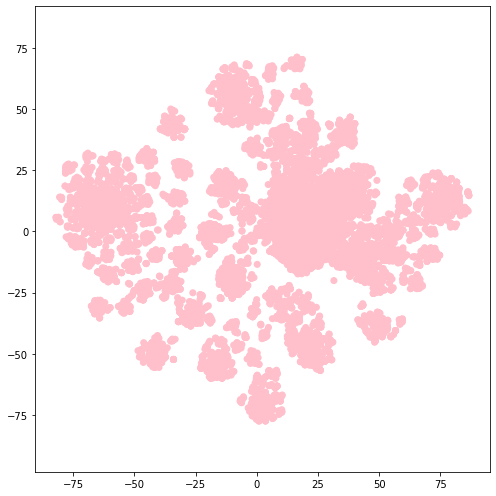

In [73]:
plt.figure(figsize=(7, 7))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], marker='o', s=50, edgecolor='None', c='pink')

plt.tight_layout()
plt.axis('equal')
plt.show()

In [81]:
tsne_results.shape

(10521, 2)

#### Exploring smaller subgroups

Currently assuming the results of t-SNE are in the same order as the words in the dataframe, will look into this later.

In [90]:
new_tsne_results = []
results_with_words = []

for i, result in enumerate(tsne_results):
    if result[0] > 57.5 and result[1] < -25:
        new_tsne_results.append(result)
        results_with_words.append([result, df.columns[i]])

In [91]:
len(new_tsne_results)

19

In [93]:
results_with_words

[[array([ 58.923492, -36.330746], dtype=float32), 'arvutikomplekt'],
 [array([ 58.511322, -37.90828 ], dtype=float32), 'e-pangandus'],
 [array([ 58.201675, -36.02285 ], dtype=float32), 'elamurajoon'],
 [array([ 59.552544, -35.72557 ], dtype=float32), 'infokanal'],
 [array([ 58.758   , -36.720566], dtype=float32), 'isamaalane'],
 [array([ 58.84491, -36.44017], dtype=float32), 'kaitsekulutus'],
 [array([ 59.479164, -35.900948], dtype=float32), 'kasutuselevõtmine'],
 [array([ 58.444504, -36.632168], dtype=float32), 'linnavõim'],
 [array([ 59.30101 , -36.018623], dtype=float32), 'maailmapoliitika'],
 [array([ 59.375183, -35.940887], dtype=float32), 'mobiilside'],
 [array([ 58.49458, -37.85811], dtype=float32), 'pommiähvardus'],
 [array([ 59.038902, -35.901638], dtype=float32), 'pürgimus'],
 [array([ 59.048447, -36.295227], dtype=float32), 'sigadus'],
 [array([ 58.854618, -36.473793], dtype=float32), 'sotsiaalteadlane'],
 [array([ 58.68834 , -36.935997], dtype=float32), 'transpordikulu'],
 

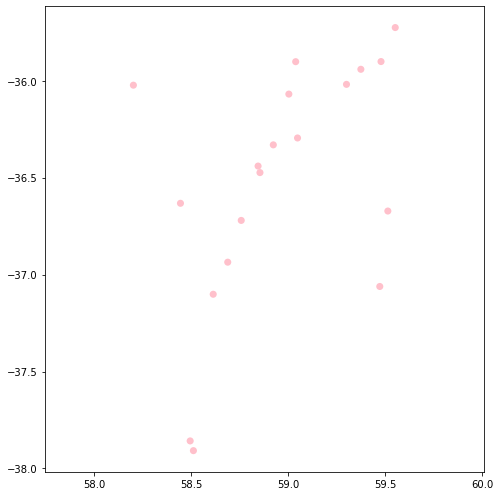

In [92]:
plt.figure(figsize=(7, 7))
plt.scatter([r[0] for r in new_tsne_results], [r[1] for r in new_tsne_results], marker='o', s=50, edgecolor='None', c='pink')

plt.tight_layout()
plt.axis('equal')
plt.show()